In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmasher as cmr
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score


# Building Nerual Network Emulator

There are 145 features in total, 70 in-situ loading history time series and 70 summed surrounding loading history; 2 coordiate and 3 earth parameters. 

In [2]:
site_co = np.loadtxt('sia_data/sites_sed.dat',dtype = object)
site_co = np.array(site_co[:,1:],dtype=float)
site_co[:,1]-=180
sp_grid = np.loadtxt('sia_data/glgrid512_global.xyz') #512 degree spherical hamonic degree
ero_idnex =np.load('sia_data/eor_index.npy')
ero_co = np.flip(sp_grid[ero_idnex],axis=1)
to_co = np.vstack([site_co,ero_co])

In [3]:

def find_sur_index(site_co,to_co,sur_r):
    '''This function is used to find surrounding index given the surroudning 
    radius'''
    
    surrounding_index = []
    for i in range(len(site_co)):
        test_lat = site_co[i,0]
        test_lon = site_co[i,1]
        lat_selection =( (np.abs(to_co[:,0]-test_lat))>-1e-05) & ( (np.abs(to_co[:,0]-test_lat))<sur_r)
        lon_selection =( (np.abs(to_co[:,1]-test_lon))>-1e-05) & ( (np.abs(to_co[:,1]-test_lon))<sur_r)
        #distance = np.sqrt((to_co[:,0]-test_lat)**2+(to_co[:,1]-test_lon)**2)
        #selection = (distance>1e-5) & (distance<sur_r)
        #selected_index = list(np.arange(len(to_co))[selection])
        selected_index = list(np.arange(len(to_co))[lat_selection&lon_selection])
        if i in selected_index: selected_index.remove(i)
        
        if 204 in selected_index: selected_index.remove(204)
        if 205 in selected_index: selected_index.remove(205)
        if 206 in selected_index: selected_index.remove(206)
        surrounding_index.append(selected_index)
    return surrounding_index
sur_index1 = find_sur_index(site_co,to_co,1.75)#number = 25
sur_index2 = find_sur_index(site_co,to_co,2)#number = 25

In [5]:
def build_sed(sed_load,sed_def,earth_list,site_co,surrounding_index,):
    '''This function is used to build training set for NN to find statistical 
    relationship between sediment load history, earth rheological model, spatial coorelation 
    and the resulting sediment deformation history
    
    INPUTS:
    ------------------------------------------------
    sed_load: a 3d volume containing sediment accumulation thickness for 
    1d - RSL predictions produced by 382 different earth models
    2d - RSL predictions at 207 SH grids
    3d - RSL predictions at 141 time intervals

    sed_def: a 3d volume containing sediment deformation history with 
    the same format as sed_load
    
    earth_list: a list containing 382 earth model, eaching consisting of 3 parameters
    
    site_co: a list containing each site's cordinate
    
    surrounding_r: as sediment isostatic adjustment of each location is also caused by 
    its surrounding sediment load, this parameter is used to select the sourrounding 
    load'''
    X,Y = np.zeros([79074,147]),np.zeros([79074,71]) #382 earth list x 207 sites samples, 287 features
    number = 0
    for i in range(len(site_co)):
        for i2 in range(382):
            li = float(earth_list[i2][0])
            up = float(earth_list[i2][1].replace('p','.'))
            low = float(earth_list[i2][2].replace('p','.'))
            Y[number,:] = sed_def[i2,i,:]
            if i<204:
                local_load = sed_load[i2,i,:]
                surrounding_load =  np.sum(sed_load[i2,:,:][None,np.array(surrounding_index[i])],axis=1)[0]
                X[number,:] = [*local_load,*surrounding_load,*site_co[i],li,up,low]
            else:
                surrounding_load =  np.sum(sed_load[i2,:,:][None,np.array(surrounding_index[i])],axis=1)[0]
                X[number,:] = [*[0]*71,*surrounding_load,*site_co[i],li,up,low]
            number+=1
    return X,Y

def com_sed_ero(sed_mat,ero_mat,ero_factor):
    '''Comcaninate sediment loading thickness and sediment erosion thickness
    together
    '''
    zero_mat = np.zeros([sed_mat.shape[0],3,sed_mat.shape[2]])
    return np.concatenate([sed_mat,zero_mat,ero_mat*ero_factor],axis=1)
    
    

In [10]:
#load inputs and outputs data

short_index = np.arange(0,141,2)

ero_mat = np.load('sia_data/ANU_ero_thick.npy')[:,:,short_index]

ANU_mean_sed_load = np.load('sia_data/ANU_up_to_output_thick.npy')[:,:,short_index]
ANU_mean_sed_load = com_sed_ero(ANU_mean_sed_load,ero_mat,1)
ANU_max_sed_load = np.load('sia_data/ANU_up_to_output_thick_382_max.npy')[:,:,short_index]
ANU_max_sed_load = com_sed_ero(ANU_max_sed_load,ero_mat,1.396)
ANU_min_sed_load = np.load('sia_data/ANU_up_to_output_thick_382_min.npy')[:,:,short_index]
ANU_min_sed_load = com_sed_ero(ANU_min_sed_load,ero_mat,0.604)
ANU_random1_sed_load = np.load('sia_data/ANU_up_to_output_thick_random_1.npy')[:,:,short_index]
ANU_random1_sed_load = com_sed_ero(ANU_random1_sed_load,ero_mat,1)
ANU_random2_sed_load = np.load('sia_data/ANU_up_to_output_thick_random_2.npy')[:,:,short_index]
ANU_random2_sed_load = com_sed_ero(ANU_random2_sed_load,ero_mat,1)
ANU_random3_sed_load = np.load('sia_data/ANU_up_to_output_thick_random_3.npy')[:,:,short_index]
ANU_random3_sed_load = com_sed_ero(ANU_random3_sed_load,ero_mat,1)

#------output deformation history---------
ANU_mean_sed_def = np.load('sia_data/ANU_mean_def.npy')[:,:,short_index]
ANU_max_sed_def = np.load('sia_data/ANU_max_def.npy')[:,:,short_index]
ANU_min_sed_def = np.load('sia_data/ANU_min_def.npy')[:,:,short_index]
ANU_random1_sed_def = np.load('sia_data/ANU_random_1_def.npy')[:,:,short_index]
ANU_random2_sed_def = np.load('sia_data/ANU_random_2_def.npy')[:,:,short_index]
ANU_random3_sed_def = np.load('sia_data/ANU_random_3_def.npy')[:,:,short_index]

earth_list = np.loadtxt('sia_data/earth_list',dtype=object)


In [11]:
surrounding_index = find_sur_index(site_co,to_co,2.5)

#------ANU--------
ANU_mean_X,ANU_mean_Y = build_sed(ANU_mean_sed_load,ANU_mean_sed_def,earth_list,site_co,surrounding_index)
ANU_max_X,ANU_max_Y = build_sed(ANU_max_sed_load,ANU_max_sed_def,earth_list,site_co,surrounding_index)
ANU_min_X,ANU_min_Y = build_sed(ANU_min_sed_load,ANU_min_sed_def,earth_list,site_co,surrounding_index)
ANU_random1_X,ANU_random1_Y = build_sed(ANU_random1_sed_load,ANU_random1_sed_def,earth_list,site_co,surrounding_index)
ANU_random2_X,ANU_random2_Y = build_sed(ANU_random2_sed_load,ANU_random2_sed_def,earth_list,site_co,surrounding_index)
ANU_random3_X,ANU_random3_Y = build_sed(ANU_random3_sed_load,ANU_random3_sed_def,earth_list,site_co,surrounding_index)

X_all  = np.vstack([ANU_mean_X,ANU_max_X,ANU_min_X,ANU_random1_X,ANU_random2_X,ANU_random3_X])
Y_all  = np.vstack([ANU_mean_Y,ANU_max_Y,ANU_min_Y,ANU_random1_Y,ANU_random2_Y,ANU_random3_Y])

In [12]:
def normaliz_X(X,return_mean=False):
    
    normal_X = np.zeros(X.shape)
    mean_list = []
    std_list = []
    for i in range(X.shape[1]):
        normal_X[:,i] = (X[:,i] - np.mean(X[:,i]))/np.std(X[:,i])
        mean_list.append(np.mean(X[:,i]))
        std_list.append(np.std(X[:,i]))
    normal_X[np.isnan(normal_X)] =0
    if return_mean==False:
        return normal_X
    else:
        return normal_X,np.array(mean_list),np.array(std_list)


In [13]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

#Normalising all the features 
nor_X,model_mean,model_std = normaliz_X(X_all,return_mean=True)

X_train, X_test, Y_train, y_test = train_test_split(nor_X, Y_all,test_size=int(len(nor_X)/10))


## Training Neural Network

In [535]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

mlp = MLPRegressor(hidden_layer_sizes=([256]*5+[128]*5),max_iter=2000,alpha=1e-10,
                  solver='adam',verbose=True,early_stopping=False,tol=1e-11,n_iter_no_change=1000,
                  learning_rate='adaptive')
mlp.fit(X_train,Y_train)
print("Training set score: %f" %mlp.score(X_train,Y_train))
print("Training set mean square error %f" %np.mean((Y_train-mlp.predict(X_train))**2))
print("Test set score: %f" %mlp.score(X_test,y_test))
print("Test set mean square error %f" %np.mean((y_test-mlp.predict(X_test))**2))


# #Save and load NN model
# import pickle
# pkl_filename = "SIA_emulator.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(mlp, file)

Iteration 1, loss = 0.00151810
Iteration 2, loss = 0.00057120
Iteration 3, loss = 0.00043918
Iteration 4, loss = 0.00037548
Iteration 5, loss = 0.00032748
Iteration 6, loss = 0.00030249
Iteration 7, loss = 0.00028457
Iteration 8, loss = 0.00026624
Iteration 9, loss = 0.00025624
Iteration 10, loss = 0.00024552
Iteration 11, loss = 0.00023250
Iteration 12, loss = 0.00022182
Iteration 13, loss = 0.00021775
Iteration 14, loss = 0.00021921
Iteration 15, loss = 0.00020093
Iteration 16, loss = 0.00019976
Iteration 17, loss = 0.00019209
Iteration 18, loss = 0.00018967
Iteration 19, loss = 0.00018669
Iteration 20, loss = 0.00018023
Iteration 21, loss = 0.00017971
Iteration 22, loss = 0.00017624
Iteration 23, loss = 0.00016747
Iteration 24, loss = 0.00016844
Iteration 25, loss = 0.00016386
Iteration 26, loss = 0.00016193
Iteration 27, loss = 0.00015628
Iteration 28, loss = 0.00015505
Iteration 29, loss = 0.00015129
Iteration 30, loss = 0.00014962
Iteration 31, loss = 0.00015004
Iteration 32, los

Iteration 253, loss = 0.00005363
Iteration 254, loss = 0.00005923
Iteration 255, loss = 0.00005436
Iteration 256, loss = 0.00005400
Iteration 257, loss = 0.00005677
Iteration 258, loss = 0.00006391
Iteration 259, loss = 0.00005520
Iteration 260, loss = 0.00005432
Iteration 261, loss = 0.00005429
Iteration 262, loss = 0.00005372
Iteration 263, loss = 0.00005574
Iteration 264, loss = 0.00005340
Iteration 265, loss = 0.00005313
Iteration 266, loss = 0.00005393
Iteration 267, loss = 0.00005393
Iteration 268, loss = 0.00005535
Iteration 269, loss = 0.00005404
Iteration 270, loss = 0.00005275
Iteration 271, loss = 0.00005294
Iteration 272, loss = 0.00005489
Iteration 273, loss = 0.00005279
Iteration 274, loss = 0.00005548
Iteration 275, loss = 0.00005312
Iteration 276, loss = 0.00005317
Iteration 277, loss = 0.00005271
Iteration 278, loss = 0.00005329
Iteration 279, loss = 0.00005218
Iteration 280, loss = 0.00005569
Iteration 281, loss = 0.00005143
Iteration 282, loss = 0.00005259
Iteration 

Iteration 502, loss = 0.00004490
Iteration 503, loss = 0.00004592
Iteration 504, loss = 0.00004647
Iteration 505, loss = 0.00004529
Iteration 506, loss = 0.00004593
Iteration 507, loss = 0.00004486
Iteration 508, loss = 0.00004486
Iteration 509, loss = 0.00004458
Iteration 510, loss = 0.00004486
Iteration 511, loss = 0.00004499
Iteration 512, loss = 0.00004460
Iteration 513, loss = 0.00004522
Iteration 514, loss = 0.00004408
Iteration 515, loss = 0.00004480
Iteration 516, loss = 0.00004496
Iteration 517, loss = 0.00004494
Iteration 518, loss = 0.00004436
Iteration 519, loss = 0.00004622
Iteration 520, loss = 0.00004414
Iteration 521, loss = 0.00004518
Iteration 522, loss = 0.00004570
Iteration 523, loss = 0.00004521
Iteration 524, loss = 0.00004621
Iteration 525, loss = 0.00004412
Iteration 526, loss = 0.00004481
Iteration 527, loss = 0.00004515
Iteration 528, loss = 0.00004413
Iteration 529, loss = 0.00004555
Iteration 530, loss = 0.00004477
Iteration 531, loss = 0.00004419
Iteration 

/Users/yucheng/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Training set score: 0.987436
Training set mean square error 0.153957
Test set score: 0.984795
Test set mean square error 0.154136


In [655]:
print("Training set score: %f" %mlp.score(X_train,Y_train))
print("Training set mean square error %f" %np.mean((Y_train-mlp.predict(X_train))**2))
print("Test set score: %f" %mlp.score(X_test,y_test))
print("Test set mean square error %f" %np.mean((y_test-mlp.predict(X_test))**2))

R2_score = r2_score(y_test,mlp.predict(X_test))
exp_var_score = explained_variance_score(y_test,mlp.predict(X_test))
print('R2 Score {:5.4f}'.format(R2_score))
print('Explained Varience Score {:5.4f}'.format(exp_var_score))

Training set score: 0.988668
Training set mean square error 0.000064
Test set score: 0.985550
Test set mean square error 0.000152
R2 Score 0.9856
Explained Varience Score 0.9858


In [24]:
import matplotlib
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   :  25}
matplotlib.rc('font', **font)

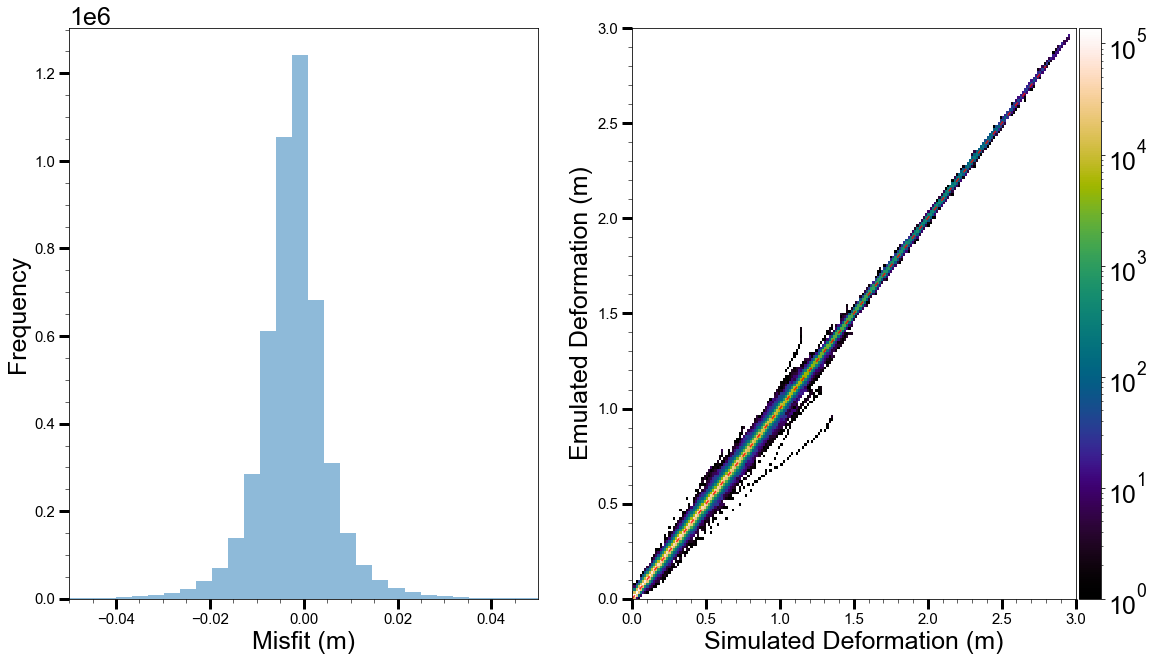

In [58]:
import matplotlib as mpl
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(22,10))
axs = plt.subplot(121)
axs.minorticks_on()
axs.tick_params(labelsize=15, pad=4,which='major',direction='out',length=10,width=3)
axs.tick_params(which='minor', length=4, color='k')

axs.hist((y_test-mlp.predict(X_test)).flatten(),200,alpha=0.5)
axs.set_xlim(-0.05,0.05)
#plt.vlines(0,0,5e5,color='r',linestyle='--')
axs.set_xlabel('Misfit (m)')
axs.set_ylabel('Frequency')

axs = plt.subplot(122)
axs.minorticks_on()
axs.tick_params(labelsize=15, pad=4,which='major',direction='out',length=10,width=3)
axs.tick_params(which='minor', length=4, color='k')
axs.plot([0,2.8],[0,2.8],'--r', dashes=(3, 5),alpha=0.8)
counts, xedges, yedges, im  = axs.hist2d(y_test.flatten(),mlp.predict(X_test).flatten(),norm=LogNorm(),bins=200,cmap=cmr.rainforest)

#plt.plot([0,1.65],[0,1.65],'--',color='r',alpha=0.5,linewidth=3, dashes=(6, 8))
divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs.set_xlabel('Simulated Deformation (m)')
axs.set_ylabel('Emulated Deformation (m)')
axs.set_xlim(0,3)
axs.set_ylim(0,3)
fig.set_size_inches(18.5, 10.5)
plt.savefig('Emulator.pdf',dpi=150)